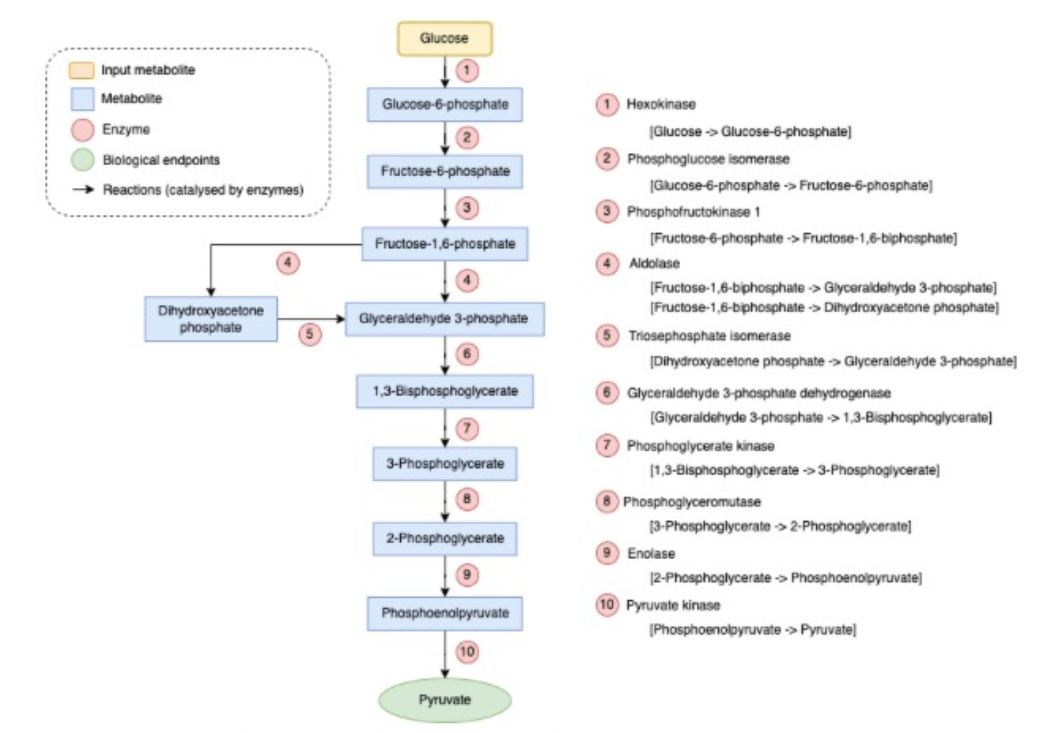
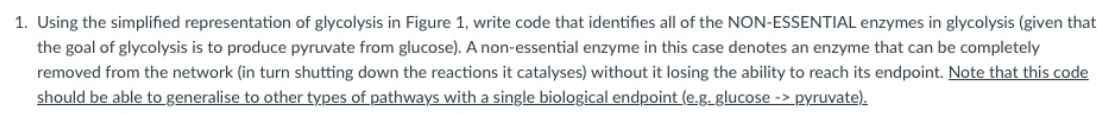

In [2]:
import csv


def read_graph(filename):
     # Metabolyte -> (Metabolyte,Enzyme)
    graph = {}  
    with open(filename, "r") as f:
        reader = csv.reader(f)
        next(reader)            # skip header

        for metabolyte_from, metabolyte_to, enzyme in reader:
            if metabolyte_from in graph:
                graph[metabolyte_from].append((metabolyte_to, enzyme))
            else:
                graph[metabolyte_from] = [(metabolyte_to, enzyme)]

    return graph
            

filename = "example_file.csv"
graph = read_graph(filename)
graph

{'Glucose': [('Glucose-6-phosphate', 'Hexokinase')],
 'Glucose-6-phosphate': [('Fructose-6-phosphate', 'Phosphoglucose isomerase')],
 'Fructose-6-phosphate': [('Fructose-1,6-phosphate', 'Phosphofructokinase 1')],
 'Fructose-1,6-phosphate': [('Dihydroxyacetone phosphate', 'Aldolase'),
  ('Glyceraldehyde 3-phosphate', 'Aldolase')],
 'Dihydroxyacetone phosphate': [('Glyceraldehyde 3-phosphate',
   'Triosephosephate isomerase')],
 'Glyceraldehyde 3-phosphate': [('1,3-Bisphosphoglycerate',
   'Glyceraldehyde 3-phosphate dehydrogenase')],
 '1,3-Bisphosphoglycerate': [('3-Phosphoglycerate',
   'Phosphoglycerate kinase')],
 '3-Phosphoglycerate': [('2-Phosphoglycerate', 'Phosphoglyceromutase')],
 '2-Phosphoglycerate': [('Phosphoenolpyruvate', 'Enolase')],
 'Phosphoenolpyruvate': [('Pyruvate', 'Pyruvate kinase')]}

In [8]:
class Path:
    def __init__(self, entries=None) -> None:
        self.entries = entries if (entries is not None) else []
        self.visited = {node for node, enzyme in entries} if entries else set()

    def add_entry(self, node, enzyme):
        self.entries.append((node, enzyme))
        self.visited.add(node)

    def  __repr__(self) -> str:
        return repr(self.entries)


def find_all_paths(graph, start_node, end_node):
    paths = []

    start_path = Path(entries=[(start_node, None)])
    frontier = [start_path]                   # Which nodes to visit next

    while frontier:
        path = frontier.pop()
        node, enzyme = path.entries[-1]

        if node == end_node:
            curr_node, curr_enzyme = node, enzyme
            path.add_entry(curr_node, curr_enzyme)
            paths.append(path)
            continue

        for (node_to, enzyme_to) in graph[node]:
            if node_to in path.visited:    # Visited but not terminating -> We are headed to dead end
                continue

            new_path = Path(entries=path.entries.copy())
            new_path.add_entry(node_to, enzyme_to)
            frontier.append(new_path)

    return paths

start_metabolyte = "Glucose"
end_metabolyte = "Pyruvate"
all_paths = find_all_paths(graph, start_metabolyte, end_metabolyte)
all_paths

[[('Glucose', None), ('Glucose-6-phosphate', 'Hexokinase'), ('Fructose-6-phosphate', 'Phosphoglucose isomerase'), ('Fructose-1,6-phosphate', 'Phosphofructokinase 1'), ('Glyceraldehyde 3-phosphate', 'Aldolase'), ('1,3-Bisphosphoglycerate', 'Glyceraldehyde 3-phosphate dehydrogenase'), ('3-Phosphoglycerate', 'Phosphoglycerate kinase'), ('2-Phosphoglycerate', 'Phosphoglyceromutase'), ('Phosphoenolpyruvate', 'Enolase'), ('Pyruvate', 'Pyruvate kinase'), ('Pyruvate', 'Pyruvate kinase')],
 [('Glucose', None), ('Glucose-6-phosphate', 'Hexokinase'), ('Fructose-6-phosphate', 'Phosphoglucose isomerase'), ('Fructose-1,6-phosphate', 'Phosphofructokinase 1'), ('Dihydroxyacetone phosphate', 'Aldolase'), ('Glyceraldehyde 3-phosphate', 'Triosephosephate isomerase'), ('1,3-Bisphosphoglycerate', 'Glyceraldehyde 3-phosphate dehydrogenase'), ('3-Phosphoglycerate', 'Phosphoglycerate kinase'), ('2-Phosphoglycerate', 'Phosphoglyceromutase'), ('Phosphoenolpyruvate', 'Enolase'), ('Pyruvate', 'Pyruvate kinase'), 

In [14]:
def find_nonessential_enzymes_in_paths(paths):
    enzymes = [set((enzyme for _, enzyme in path.entries)) for path in paths]
    enzyme_intersection = enzymes[0].copy()
    enzyme_union = enzymes[0].copy()

    for enzyme in enzymes[1:]:
        enzyme_intersection.intersection_update(enzyme)
        enzyme_union.update(enzyme)

    non_essentials = enzyme_union.difference(enzyme_intersection)
    return non_essentials


find_nonessential_enzymes_in_paths(all_paths)

{'Triosephosephate isomerase'}